# Canon Maker

In [1]:
from music21 import *
import copy
import numpy as np
import pylab as pl
import os

Here are some scores to use for various arguments. WTC contains separate .xml files for each subject from Bach's Well-Tempered Clavier. It should be passed through "comparison" function, the rest should pass through "multi_tester."

In [2]:
WTC = '/Users/Daniel/OneDrive/FSU/Fall 2015/Seminar/Final Project/Bach WTC Subjects/'
wtc1_Bfmin = converter.parse('/Users/Daniel/OneDrive/FSU/Fall 2015/Seminar/Final Project/Prolation tests/Bach WTC1 Bfmin.xml')
wtc1_Cmaj = converter.parse('/Users/Daniel/OneDrive/FSU/Fall 2015/Seminar/Final Project/Prolation tests/Bach WTC1 Cmaj.xml')
twinkle = converter.parse('/Users/Daniel/OneDrive/FSU/Fall 2015/Seminar/Final Project/Prolation tests/Twinkle.xml')
twink = converter.parse('/Users/Daniel/OneDrive/FSU/Fall 2015/Seminar/Final Project/Prolation tests/TwinkleShort.xml')
row = converter.parse('/Users/Daniel/OneDrive/FSU/Fall 2015/Seminar/Final Project/Prolation tests/row.xml')
boat = converter.parse('/Users/Daniel/OneDrive/FSU/Fall 2015/Seminar/Final Project/Prolation tests/realRow.xml')

These are globals for testing various parameters such as prolation and transposition amounts. The empty dictionaries are for collecting data.

In [3]:
prolation_amount = [1, 1.25, 1.5, 1.75, 2, .75, .5]
transposition_amount = [-8, -7, -6, -5, -4, -3, -2, 1, 2, 3, 4, 5, 6, 7, 8]
prolation_dict = {}
offset_dict = {}
transposition_dict = {}
all_dict = {}
corpus_dict = {}
a = corpus.getComposer('palestrina')

This function is computationally the largest and takes a corpus of melodies. The melodies are combined with an altered form of themselves (a combination of offset, prolation, and/or transposition). Each resulting 2-voice score is tested for correct counterpoint, and the data for the tests is returned in a dictionary and a histogram. 

In [4]:
def comparison(songs):
    list_songs = []
    for root, dirs, files in os.walk(songs):
        for file_name in files:
            path = os.path.join(root, file_name)
            tempStream = converter.parse(path)
            list_songs.append(tempStream)
    for song in list_songs:
        corpus_dict[list_songs.index(song)] = multi_tester(song)
    X = np.arange(len(corpus_dict))
    pl.title('Canon Success in Bach\'s WTC')
    pl.ylabel('number of canons')
    pl.xlabel('subjects from WTC')
    pl.bar(X, corpus_dict.values(), align='center', width=0.5)
    pl.xticks(X, corpus_dict.keys())
    ymax = max(corpus_dict.values()) + 1
    pl.ylim(0, ymax)
    pl.show()
    print(corpus_dict)

This function is for single melodies and does the same as described in the above function (which passes each melody through this function). If desired, it will combine each passed melody onto a single score or as a midi file.

In [5]:
def multi_tester(melody):
    alls = []
    trues = []
    # s = stream.Stream()
    for x in transposition_amount:
        for y in prolation_amount:
            for z in range(int(melody.flat.notesAndRests.quarterLength / 2)):
                alls.append(score_maker(melody, offsets(prolations(d_transpositions(melody, x), y), z)))
    for p in alls:
        tests = intervalStream(p)
        if (parallel_checker(tests)) == False or (resolve_diss(tests)) == False:
            all_dict[p] = False
        elif (parallel_checker(tests)) == True and (resolve_diss(tests)) == True:
            all_dict[p] = True
            trues.append(p)
            # p.show()
    print("true: ", len(trues))
    print("total: ", len(alls))
    percentage = float(len(trues)) / float(len(alls)) * 100.0
    print(percentage, "percent")
    print(len(trues))
    s = stream.Score()
    for x in range(1, len(trues)):
        f1 = trues[x-1]
        f11 = trues[x]
        if s.duration.quarterLength <1:
            s.insert(0, copy.deepcopy(f1[0]))
            s.insert(0, copy.deepcopy(f1[1]))
            s[0].insertAndShift(s.duration.quarterLength, copy.deepcopy(f11[0]))
            s[1].insertAndShift(s[1].duration.quarterLength, copy.deepcopy(f11[1]))
        else:
            s[0].insertAndShift(s[0].duration.quarterLength, copy.deepcopy(f11[0]))
            s[1].insertAndShift(s[1].duration.quarterLength, copy.deepcopy(f11[1]))
    s.show()
    s.show('midi')
    return len(trues)
    # return percentage
    # print all_dict
    # return all_dict

This function is to test a single parameter and to get statistics on that parameter given a melody. It is not called in the other functions.

In [6]:
def tester(melody, function, amounts, dict):
    for p in amounts:
        tests = intervalStream(score_maker(melody, function(melody, p)))
        if (parallel_checker(tests)) == False or (resolve_diss(tests)) == False:
            dict[p] = False
        elif (parallel_checker(tests)) == True and (resolve_diss(tests)) == True:
            dict[p] = True
    print(function, amounts, dict)
    return dict

The score_maker takes the original melody and combines it with the altered melody into a 2-voice score. The altered melody is trimmed or elongated to make the parts of equal length. 

In [7]:
def score_maker(melody, function):
    score = stream.Score(id='canon')
    p1 = stream.Part(id='melody')
    p1.append(melody)
    w = stream.Stream()
    x = stream.Stream(function)
    for n in x.flat.notesAndRests:
        if w.duration.quarterLength + n.duration.quarterLength <= melody.duration.quarterLength:
            w.append(n)
    if w.duration.quarterLength < melody.duration.quarterLength:
        w.append(note.Rest(quarterLength=abs(w.duration.quarterLength - melody.duration.quarterLength)))
    p2 = stream.Part(id='canon')
    p2.append(w)
    score.insert(0, p1)
    score.insert(0, p2)
    return score

This function returns diatonic transpositions of the melody. It takes a generic interval and adjusts any chromatic pitches to the given key. 

In [8]:
def d_transpositions(melody, transposition):
    newMelody = copy.deepcopy(melody)
    tStream = newMelody.parts[0].flat.transpose(interval.GenericInterval(transposition))
    for n in tStream.notes:
        n.pitch.accidental = melody.flat.getContextByClass(key.KeySignature).accidentalByStep(n.step)
    return tStream

This offsets the given melody by a particular amount by creating a rest at the beginning of the stream.

In [9]:
def offsets(melody, offset):
    s = copy.deepcopy(melody)
    s.insertAndShift(note.Rest(quarterLength=offset))
    return s

Prolations augments or diminishes the rhythmic values of the melody by a given amount.

In [10]:
def prolations(melody, time):
    newMelody = copy.deepcopy(melody)
    prolation = stream.Stream()
    for n in newMelody.flat.notesAndRests:
        n.quarterLength = (n.quarterLength * time)
        prolation.append(n)
    return prolation

This takes the score created with the score_maker, "chordify's" it, finds the mod-12 intervals, and places them in a list to be tested.

In [11]:
def intervalStream(element):
    """chordifys the two melodies and gets a list of intervals"""
    chords = element
    harmonies = chords.chordify(removeRedundantPitches=True)
    harm = harmonies.flat.getElementsByClass('Chord')
    intervals = []
    final_ints = []
    for x in harm:
        if len(x) == 2:
            intervals.append(x)
    for x, y in intervals:
        final_ints.append(abs((x.pitch.midi - y.pitch.midi) % 12))
    return final_ints

This checks for parallel fifths, octaves, unisons, and too many 6ths and 3rds. You can adjust the "checker" threshold to allow for a few parallels. 

In [12]:
def parallel_checker(intervals):
    checker = 1
    parallel_fifths = 0
    parallel_octaves = 0
    thirds = [3, 4]
    sixths = [8, 9]
    for x in range(1, len(intervals)):
        if intervals[x] == 7 and intervals[x - 1] == 7:
            # print "parallel fifths"
            checker += 1
            parallel_fifths += 1
        elif intervals[x] == 0 and intervals[x - 1] == 0:
            # print "parallel octaves"
            checker += 1
            parallel_octaves += 1
    for x in range(3, len(intervals)):
        if intervals[x - 3] in thirds and intervals[x - 2] in thirds and intervals[x - 1] in thirds \
                and intervals[x] in thirds:
            checker += 1
            # print "3 motion too similar"
        elif intervals[x - 3] in sixths and intervals[x - 2] in sixths and intervals[x - 1] in sixths \
                and intervals[x] in sixths:
            checker += 1
            # print "6 motion too similar"
    if checker > 1:
        return False
    else:
        return True

This checks the resolution of a given dissonance. I hope to better nuance this part to look for neighboring and passing motion, but it rejects undesirable results as is. There are some upcoming functions and methods in music21 that are being developed that can be used in place of this that will provide more nuance. 

In [13]:
def resolve_diss(intervals):
    checker = 1
    seconds = [1, 2]
    sevenths = [10, 11]
    dissonant = [1, 2, 5, 6, 10, 11]
    for x in range(1, len(intervals)):
        if intervals[x - 1] in dissonant and intervals[x] in dissonant:
            checker += 1
            print('dissonant buddy')
        elif intervals[x - 1] == 6 and intervals[x] != (4 or 3 or 9 or 8):
            checker += 1
            # print("bad tritone resolution")
        elif intervals[x - 1] == 5 and intervals[x] != (4 or 3 or 7 or 8 or 9):
            checker += 1
        elif intervals[x - 1] in seconds and intervals[x] != (4 or 3 or 0):
            checker += 1
            # print("bad 2, bad 2")
        elif intervals[x - 1] == sevenths and intervals[x] != (0 or 9 or 8):
            checker += 1
            # print("bad 7, bad 7")
    if checker > 1:
        return False
    else:
        return True

Here are examples of what to call to get things going:

In [14]:
# comparison(WTC)
# multi_tester(wtc1_Bfmin)

# Similarity

This module takes data from CanonMaker and finds correlations. Here is some data included as lists or dictionaries as well as modules to import.

In [15]:
from music21 import *
import numpy as np
import pylab as pl
import os
from scipy import spatial, stats


WTC = '/Users/Daniel/OneDrive/FSU/Fall 2015/Seminar/Final Project/Bach WTC Subjects/'
wtc1_Bfmin = converter.parse('/Users/Daniel/OneDrive/FSU/Fall 2015/Seminar/Final Project/Prolation tests/Bach WTC1 Bfmin.xml')
canon_data = {}
WTC1_canonPercent = {0: 3.3333333333333335, 1: 1.4814814814814816, 2: 11.481481481481481, 3: 40.74074074074074, 4: 10.0, 5: 1.6666666666666667, 6: 0.0, 7: 0.7407407407407408, 8: 15.0, 9: 0.0, 10: 1.6666666666666667, 11: 11.666666666666666, 12: 5.9259259259259265, 13: 1.4814814814814816, 14: 0.0, 15: 29.444444444444446, 16: 38.333333333333336, 17: 1.4814814814814816, 18: 2.2222222222222223, 19: 1.1111111111111112, 20: 0.0, 21: 12.222222222222221, 22: 5.185185185185185, 23: 0.5555555555555556}
WTC2_canonPercent = {24: 0.8888888888888888, 25: 25.0, 26: 5.555555555555555, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.31746031746031744, 31: 1.4814814814814816, 32: 16.38888888888889, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 1.6666666666666667, 38: 0.0, 39: 0.6349206349206349, 40: 0.0, 41: 0.0, 42: 0.0, 43: 19.25925925925926, 44: 0.0, 45: 0.0, 46: 1.7777777777777777, 47: 0.0}
WTC2_length = {24: 29, 25: 12, 26: 16, 27: 23, 28: 12, 29: 24, 30: 23, 31: 18, 32: 8, 33: 55, 34: 25, 35: 28, 36: 25, 37: 25, 38: 45, 39: 25, 40: 25, 41: 26, 42: 24, 43: 14, 44: 26, 45: 32, 46: 15, 47: 23}
WTC1_length = {0: 17, 1: 25, 2: 22, 3: 4, 4: 18, 5: 14, 6: 28, 7: 15, 8: 20, 9: 24, 10: 23, 11: 15, 12: 21, 13: 22, 14: 33, 15: 16, 16: 10, 17: 19, 18: 17, 19: 18, 20: 41, 21: 13, 22: 17, 23: 25}
wtc_length = {0: 17, 1: 25, 2: 22, 3: 4, 4: 18, 5: 14, 6: 28, 7: 15, 8: 20, 9: 24, 10: 23, 11: 15, 12: 21, 13: 22, 14: 33, 15: 16, 16: 10, 17: 19, 18: 17, 19: 18, 20: 41, 21: 13, 22: 17, 23: 25, 24: 29, 25: 12, 26: 16, 27: 23, 28: 12, 29: 24, 30: 23, 31: 18, 32: 8, 33: 55, 34: 25, 35: 28, 36: 25, 37: 25, 38: 45, 39: 25, 40: 25, 41: 26, 42: 24, 43: 14, 44: 26, 45: 32, 46: 15, 47: 23}
wtc_data = {0: 3.3333333333333335, 1: 1.4814814814814816, 2: 11.481481481481481, 3: 40.74074074074074, 4: 10.0, 5: 1.6666666666666667, 6: 0.0, 7: 0.7407407407407408, 8: 15.0, 9: 0.0, 10: 1.6666666666666667, 11: 11.666666666666666, 12: 5.9259259259259265, 13: 1.4814814814814816, 14: 0.0, 15: 29.444444444444446, 16: 38.333333333333336, 17: 1.4814814814814816, 18: 2.2222222222222223, 19: 1.1111111111111112, 20: 0.0, 21: 12.222222222222221, 22: 5.185185185185185, 23: 0.5555555555555556, 24: 0.8888888888888888, 25: 25.0, 26: 5.555555555555555, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.31746031746031744, 31: 1.4814814814814816, 32: 16.38888888888889, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 1.6666666666666667, 38: 0.0, 39: 0.6349206349206349, 40: 0.0, 41: 0.0, 42: 0.0, 43: 19.25925925925926, 44: 0.0, 45: 0.0, 46: 1.7777777777777777, 47: 0.0}
rhythmic_variance = [30.59523809523809, 37.77777777777778, 22.22222222222222, 44.444444444444436, 67.88048552754435, 19.487179487179485, 21.7283950617284, 24.28571428571428, 20.350877192982455, 0.0, 14.545454545454545, 22.857142857142858, 33.25396825396825, 49.2063492063492, 28.749999999999996, 38.22222222222222, 22.22222222222222, 18.51851851851852, 8.333333333333332, 27.45098039215686, 9.666666666666666, 11.111111111111109, 40.833333333333336, 15.555555555555555, 14.285714285714283, 23.030303030303028, 23.703703703703702, 3.03030303030303, 24.24242424242424, 4.347826086956523, 33.333333333333336, 33.893557422969195, 28.571428571428573, 25.008818342151674, 18.055555555555554, 9.876543209876543, 29.682539682539687, 42.77777777777777, 2.727272727272727, 22.222222222222218, 26.66666666666667, 5.333333333333332, 20.289855072463766, 15.384615384615385, 5.333333333333332, 18.924731182795696, 28.571428571428566, 14.545454545454545]
WTC_canonNumber = {0: 6, 1: 4, 2: 31, 3: 110, 4: 18, 5: 3, 6: 0, 7: 2, 8: 27, 9: 0, 10: 3, 11: 42, 12: 16, 13: 8, 14: 0, 15: 106, 16: 69, 17: 4, 18: 4, 19: 2, 20: 0, 21: 44, 22: 14, 23: 2, 24: 2, 25: 45, 26: 10, 27: 0, 28: 0, 29: 0, 30: 2, 31: 4, 32: 59, 33: 0, 34: 0, 35: 0, 36: 0, 37: 6, 38: 0, 39: 2, 40: 0, 41: 0, 42: 0, 43: 52, 44: 0, 45: 0, 46: 8, 47: 0}
melodic_variation = [78.6497713398284, 90.76726744416143, 70.1004947114358, 86.60254037844386, 101.6782254883588, 82.21888548451322, 71.1025401052407, 86.26058265484801, 46.97408542844452, 54.692596833785515, 68.92002730341882, 101.51286955758401, 59.22469278917488, 50.41008302500835, 90.09046988296042, 103.96522472262106, 54.609194192632145, 109.66245532978276, 41.5620909893548, 45.23443208612048, 83.87654042446768, 65.46536707079771, 79.05694150420949, 81.60579579678277, 78.72376628113507, 71.26966450997983, 66.66666666666666, 71.22108635358704, 92.96222517045284, 69.85816038567194, 82.16314960794824, 92.74230003348497, 35.35533905932738, 104.51052090383932, 70.22669219871398, 101.00021523868583, 89.16798613889469, 88.57539161640776, 46.83743350642876, 113.4552701106709, 92.52717680081582, 93.87366900090764, 59.63648483460119, 41.95235392680606, 89.18825850158447, 60.57803272210589, 77.17996763956492, 112.49402634348354]
freq_int = [2, 1, 9, -1, 2, 1, -2, -2, 2, 3, 2, -1, -2, -2, -2, 1, -4, 1, 5, 2, -2, 2, 2, -1, 2, 2, -2, 2, 0, -1, -2, -2, -2, -2, -2, 0, 2, 2, 2, 0, 2, 2, -2, -4, 0, 2, -2, 1]
first_int = [2, -1, 2, -1, 2, 2, -3, 7, 2, 3, 2, 1, 5, 2, 2, 1, 7, -1, -1, -1, 2, -5, -1, -4, -2, -4, 4, -1, 0, 2, 7, 0, 2, 2, -1, -7, -2, -4, -3, -4, -7, 2, 2, -4, -2, 2, 4, -4]
first_int_b1 = [-2, -4, 4, -1, 0, 2, 7, 0, 2, 2, -1, -7, -2, -4, -3, -4, -7, 2, 2, -4, -2, 2, 4, -4]
first_int_b2 = [2, -1, 2, -1, 2, 2, -3, 7, 2, 3, 2, 1, 5, 2, 2, 1, 7, -1, -1, -1, 2, -5, -1, -4]
key_profile = {0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 2, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 11: 5, 12: 6, 13: 6, 14: 7, 15: 7, 16: 8, 17: 8, 18: 9, 19: 9, 20: 10, 21: 10, 22: 11, 23: 11, 24: 0, 25: 0, 26: 1, 27: 1, 28: 2, 29: 2, 30: 3, 31: 3, 32: 4, 33: 4, 34: 5, 35: 5, 36: 6, 37: 6, 38: 7, 39: 7, 40: 8, 41: 8, 42: 9, 43: 9, 44: 10, 45: 10, 46: 11, 47: 11}
first_pitch = [60, 72, 68, 49, 50, 62, 70, 63, 64, 64, 60, 60, 73, 54, 67, 62, 56, 56, 69, 57, 65, 70, 59, 66, 67, 67, 49, 49, 62, 62, 51, 63, 52, 64, 65, 72, 65, 61, 74, 62, 75, 68, 57, 64, 72, 58, 47, 66]
wtc_no_prolation = {0: 12, 1: 11, 2: 10, 3: 53, 4: 10, 5: 0, 6: 4, 7: 12, 8: 6, 9: 3, 10: 0, 11: 23, 12: 6, 13: 6, 14: 0, 15: 34, 16: 26, 17: 4, 18: 0, 19: 5, 20: 0, 21: 35, 22: 16, 23: 3, 24: 0, 25: 27, 26: 15, 27: 0, 28: 2, 29: 4, 30: 14, 31: 6, 32: 60, 33: 0, 34: 2, 35: 4, 36: 0, 37: 6, 38: 0, 39: 0, 40: 2, 41: 4, 42: 0, 43: 36, 44: 3, 45: 15, 46: 44, 47: 5}
wtc_no_prolation_percent = {0: 20.0, 1: 12.222222222222221, 2: 11.11111111111111, 3: 58.88888888888889, 4: 16.666666666666664, 5: 0.0, 6: 4.444444444444445, 7: 13.333333333333334, 8: 10.0, 9: 6.666666666666667, 10: 0.0, 11: 19.166666666666668, 12: 6.666666666666667, 13: 3.3333333333333335, 14: 0.0, 15: 28.333333333333332, 16: 43.333333333333336, 17: 4.444444444444445, 18: 0.0, 19: 8.333333333333332, 20: 0.0, 21: 29.166666666666668, 22: 17.77777777777778, 23: 2.5, 24: 0.0, 25: 45.0, 26: 25.0, 27: 0.0, 28: 3.3333333333333335, 29: 6.666666666666667, 30: 6.666666666666667, 31: 6.666666666666667, 32: 50.0, 33: 0.0, 34: 4.444444444444445, 35: 6.666666666666667, 36: 0.0, 37: 5.0, 38: 0.0, 39: 0.0, 40: 2.2222222222222223, 41: 3.8095238095238098, 42: 0.0, 43: 40.0, 44: 2.857142857142857, 45: 6.666666666666667, 46: 29.333333333333332, 47: 8.333333333333332}

This takes a folder of .xml files, parses them, and returns each to a list. The purpose of this is to find data apart from CanonMaker (such as melody length).

In [16]:
def song_list(songs):
    list_songs = []
    for root, dirs, files in os.walk(songs):
        for file_name in files:
            path = os.path.join(root, file_name)
            tempStream = converter.parse(path)
            list_songs.append(tempStream)
    return list_songs

This simply finds the first scale degree of the melody:

In [17]:
def first_degree(songs):
    song_ints = []
    ints = []
    for song in song_list(songs):
        allNotes = song.flat.getElementsByClass('Note')
        midiNotes = []
        # print allNotes
        for y in allNotes:
            midiNotes.append(y.pitch.midi)
        for y in midiNotes[:1]:
            ints.append(y)
    for x in ints:
        song_ints.append(x)
    print(song_ints)
    return song_ints

These two functions find the rhythmic and melodic variability, respectively. 

In [18]:
def rhythmic_variability(songs):
    wha = []
    list_songs = []
    for root, dirs, files in os.walk(songs):
        for file_name in files:
            path = os.path.join(root, file_name)
            tempStream = converter.parse(path)
            list_songs.append(tempStream)
    for song in list_songs:
        wha.append(analysis.patel.nPVI(song.flat.notesAndRests))
    # print(wha)
    return wha


def melodic_variability(songs):
    wha = []
    list_songs = []
    for root, dirs, files in os.walk(songs):
        for file_name in files:
            path = os.path.join(root, file_name)
            tempStream = converter.parse(path)
            list_songs.append(tempStream)
    for song in list_songs:
        wha.append(song.parts.flat.NoteEditorial.melodicIntervals)
    return wha

This function makes a histogram of the most common melodic interval given the melody:

In [19]:
def interval_chart(songs):
    most_int = []
    for x in intervalStream(song_list(songs)):
        most_int.append(max(set(x), key=x.count))
    # print(most_int)
    pl.bar(range(0, 48), most_int, width=0.5)
    pl.xticks(range(0, 48))
    pl.title("Interval Sum vs Canonic Success")
    pl.ylabel("most frequent interval")
    pl.xlabel("WTC subject")
    pl.show()

This function (under construction) finds the occurance of interval type (like an interval vector for a melody):

In [20]:
def interval_comparison(songs):
    """interval makeup of entire WTC"""
    song_stuff = intervalStream(song_list(songs))
    all_intervals = []
    for x in song_stuff:
        intervalMakeup = {}
        x = sorted(x)
        for y in range(-12, 13):
            intervalMakeup[y] = 0
            for z in x:
                if z == y:
                    intervalMakeup[z] +=1
                    # else:
                    #     intervalMakeup[z] = 1
        all_intervals.append(intervalMakeup)
    # print(all_intervals)
    return all_intervals

This simply returns a list of the first interval for given melodies.

In [21]:
def firstInterval(songs):
    """gets directed melodic intervals for given list of songs"""
    song_ints = []
    for song in songs:
        allNotes = song.flat.getElementsByClass('Note')
        midiNotes = []
        ints = []
        # print allNotes
        for y in allNotes:
            midiNotes.append(y.pitch.midi)
        for z in range(1, 2):
            inter = midiNotes[z] - midiNotes[z-1]
            ints.append(inter)
        for x in ints:
            song_ints.append(x)
    print(song_ints)
    return song_ints

This gives the cosine similarity between canon success and melody length.

In [22]:
def cosine_similarity(songs):
    for x in songs.values():
        dataSetI.append(x)
    for y in wtc_length.values():
        dataSetII.append(y)
    result = 1 - spatial.distance.cosine(dataSetI, dataSetII)
    print("cosine", result)
    """result for book 1 is 0.35963251176; both books 0.273930506157"""

This function is probably the most useful for finding correlation: Pearson's R. It takes two sets of data and finds the correlation therein.

In [23]:
def pearson_sim(one, two):
    m = []
    n = []
    for x in one:
        m.append(x)
    for y in two:
        n.append(y)
    result_2 = stats.pearsonr(m, n)
    pl.scatter(m, n)
    pl.title(result_2)
    # pl.ylabel("interval sum")
    # pl.xlabel("canonic success")
    pl.show()
    print("pearson", result_2)

Lastly, this function simply returns a histogram of the WTC subject and its length:

In [24]:
def melody_length(songs):
    list_songs = []
    for root, dirs, files in os.walk(songs):
        for file_name in files:
            path = os.path.join(root, file_name)
            tempStream = converter.parse(path)
            list_songs.append(tempStream)
    for song in list_songs:
        canon_data[list_songs.index(song)] = len(song.flat.notesAndRests)
    X = np.arange(len(canon_data))
    pl.title('Subject Length in Bach\'s WTC')
    pl.ylabel('number of notes and rests')
    pl.xlabel('subjects from WTC')
    pl.bar(X, canon_data.values(), align='center', width=1)
    pl.xticks(X, canon_data.keys())
    ymax = max(canon_data.values()) + 1
    pl.ylim(0, ymax)
    pl.show()
    # print(canon_data)
    return canon_data

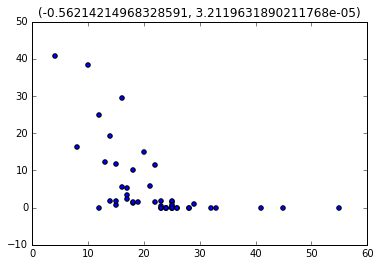

pearson (-0.56214214968328591, 3.2119631890211768e-05)


In [25]:
pearson_sim(wtc_length.values(), wtc_data.values())